## Access Mooring Southern Ocean Surface Fluxes Realtime QC (Parquet)
This Jupyter notebook demonstrates how to access and plot mooring_southern_ocean_surface_fluxes_realtime_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/80ffbf9d-9547-41aa-8fa1-cf028c58556a).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/mooring_southern_ocean_surface_fluxes_realtime_qc.ipynb).


In [1]:
dataset_name = "mooring_southern_ocean_surface_fluxes_realtime_qc"

## Install/Update packages and Load common functions

In [ ]:
import os, requests, importlib.util

open('setup.py', 'w').write(requests.get('https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/setup.py').text)

spec = importlib.util.spec_from_file_location("setup", "setup.py")
setup = importlib.util.module_from_spec(spec)
spec.loader.exec_module(setup)

setup.install_requirements()
setup.load_dataquery()

In [2]:
from DataQuery import GetAodn

# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 162 ms, sys: 27.9 ms, total: 190 ms
Wall time: 9.45 s


In [4]:
aodn_dataset.dataset.partitioning.schema

deployment_number: int32
timestamp: int32
polygon: string

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('deployment_number')
print(list(unique_partition_value)[0:8])  # showing a subset only

['4', '3', '1', '9', '-9999', '10', '2']
CPU times: user 8.99 ms, sys: 0 ns, total: 8.99 ms
Wall time: 8.47 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


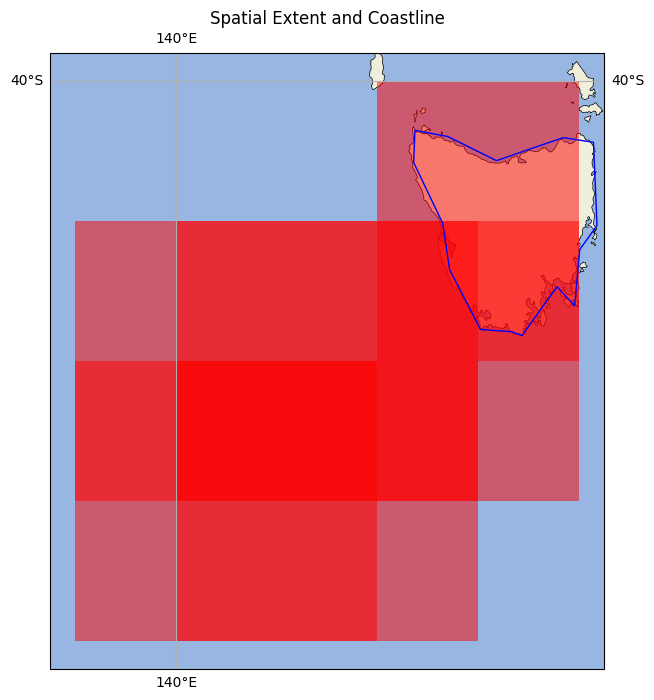

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent()

CPU times: user 1.35 s, sys: 390 ms, total: 1.74 s
Wall time: 13 s


(Timestamp('2010-03-17 12:29:00.000016896'),
 Timestamp('2021-06-21 20:59:00.000003584'))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-10-29 14:35:21,932 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_southern_ocean_surface_fluxes_realtime_qc.parquet


{'TIME': {'type': 'timestamp[ns]',
  'standard_name': 'time',
  'long_name': 'time',
  'axis': 'T',
  'valid_min': 0,
  'valid_max': 90000.0,
  'comment': 'Relative julian days with decimal part as parts of the day'},
 'LATITUDE': {'type': 'float',
  'standard_name': 'latitude',
  'long_name': 'latitude',
  'units': 'degrees_north',
  'axis': 'Y',
  'valid_min': -90,
  'valid_max': 90,
  'reference_datum': 'geographical coordinates, WGS84'},
 'LONGITUDE': {'type': 'float',
  'standard_name': 'longitude',
  'long_name': 'longitude',
  'units': 'degrees_east',
  'axis': 'X',
  'valid_min': -180,
  'valid_max': 180,
  'reference_datum': 'geographical coordinates, WGS84'},
 'PL_CMP': {'type': 'float',
  'long_name': 'compass direction',
  'units': 'degrees_north',
  'observation_type': 'measured'},
 'WDIR': {'type': 'float',
  'standard_name': 'wind_to_direction',
  'long_name': 'earth relative wind direction (oceanographic)',
  'units': 'degree',
  'observation_type': 'calculated',
  'com

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [9]:
%%time
df = aodn_dataset.get_data(date_start='2010-03-18', 
                           date_end='2019-08-01',
                           lat_min=-55, 
                           lat_max=-40, 
                           lon_min=135, 
                           lon_max=160, 
                           )

df.info()

2025-10-29 14:36:14,109 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_southern_ocean_surface_fluxes_realtime_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454515 entries, 0 to 454514
Data columns (total 48 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   TIME               454515 non-null  datetime64[ns]
 1   LATITUDE           454515 non-null  float32       
 2   LONGITUDE          454515 non-null  float32       
 3   PL_CMP             454515 non-null  float32       
 4   WDIR               454515 non-null  float32       
 5   WSPD               454515 non-null  float32       
 6   WIND_H             454515 non-null  float32       
 7   WIND_FLAG          454515 non-null  int32         
 8   ATMP               454515 non-null  float32       
 9   ATMP_H             454515 non-null  float32       
 10  ATMP_FLAG          454515 non-null  int32         
 11  AIRT               454515 non-null  float32       
 12  AIRT_H             454515 non-null  float32       
 13  AIRT_FLAG          454515 non-null  int32   

In [10]:
%%time
df = aodn_dataset.get_data(
                           scalar_filter={'deployment_number': 1}
                           )

df.info()

2025-10-29 14:36:19,137 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/mooring_southern_ocean_surface_fluxes_realtime_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124995 entries, 0 to 124994
Data columns (total 48 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   TIME               124995 non-null  datetime64[ns]
 1   LATITUDE           124995 non-null  float32       
 2   LONGITUDE          124995 non-null  float32       
 3   PL_CMP             124995 non-null  float32       
 4   WDIR               124995 non-null  float32       
 5   WSPD               124995 non-null  float32       
 6   WIND_H             124995 non-null  float32       
 7   WIND_FLAG          124995 non-null  int32         
 8   ATMP               124995 non-null  float32       
 9   ATMP_H             124995 non-null  float32       
 10  ATMP_FLAG          124995 non-null  int32         
 11  AIRT               124995 non-null  float32       
 12  AIRT_H             124995 non-null  float32       
 13  AIRT_FLAG          124995 non-null  int32   

In [11]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/home/lbesnard/github_repo/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_80ffbf9d-9547-41aa-8fa1-cf028c58556a_mooring_southern_ocean_surface_fluxes_realtime_qc_data-hash_c94ec8de.csv.zip

<Axes: title={'center': 'IMOS - Deep Water Moorings - Southern Ocean Flux Station (SOFS) - Surface fluxes (real-time)'}, xlabel='TIME', ylabel='sea_water_temperature in celsius'>

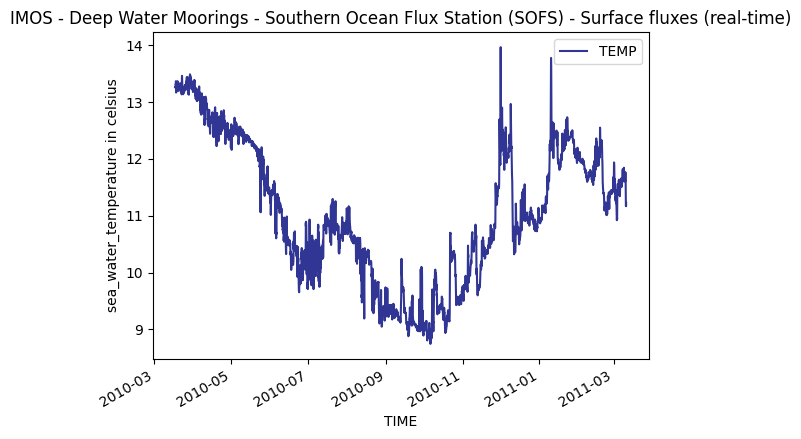

In [12]:
df.sort_values('TIME').plot(y='TEMP', x='TIME', cmap='RdYlBu_r',
                            ylabel=f"{metadata['TEMP']['standard_name']} in {metadata['TEMP']['units']}" ,
                            title=metadata['global_attributes']['title']
                           )